In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
path = './dataset'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010]
    )
])


train_dataset = datasets.CIFAR10(root=path, train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root=path, train=False, download=True, transform=transform)

class_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck"
]

Files already downloaded and verified
Files already downloaded and verified


In [3]:
print(f'Length train: {len(train_dataset)}')
print(f'Length test: {len(test_dataset)}')

Length train: 50000
Length test: 10000


In [4]:
import numpy as np

def imshow(img, title):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


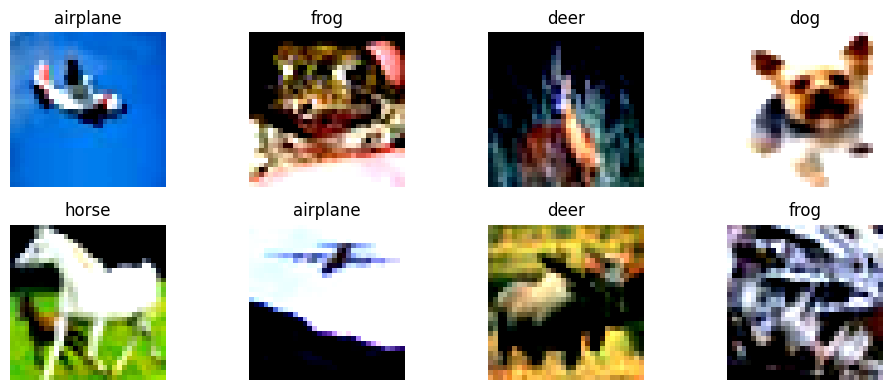

In [5]:
dataiter = iter(torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True))
images, labels = next(dataiter)

plt.figure(figsize=(10, 4))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    imshow(images[i], class_names[labels[i]])
plt.tight_layout()
plt.show()

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

Device: cuda:0


In [7]:
learning_rate = 0.001
epochs = 20
batch_size = 64

In [ ]:
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            # Block 2
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Block 4
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Block 5
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Block 6
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            # Block 7
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Block 8
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                          nn.Flatten(),
                                          nn.Dropout(0.2),
                                          nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x
    
    def predict(self, data_loader):
      tp = 0
      n = 0

      with torch.no_grad():
          for images, labels in data_loader:
              images = images.to(device)
              labels = labels.to(device)

              outputs = self.forward(images)

              predicted = torch.argmax(outputs, dim=1)

              n += labels.size(dim=0)
              tp += (predicted == labels).sum()

      return (tp / n).item()

In [ ]:
model = VGG16(num_classes=10).to(device)
cross_entropy = nn.CrossEntropyLoss().to(device)
optimizer_adam = optim.Adam(model.parameters(), lr = learning_rate)

print(f"Модель имеет {sum(p.numel() for p in model.parameters())} параметров")
print(f"Обучаемых параметров: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")


Модель имеет 4694346 параметров
Обучаемых параметров: 4694346


In [10]:
error_train_list = []
accuracy_train_list = []

train_data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

test_data_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

train_loss_list = []
train_accuracy_list = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_data_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer_adam.zero_grad()
        outputs = model(inputs)
        loss = cross_entropy(outputs, labels)
        loss.backward()
        optimizer_adam.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_data_loader)
    acc = 100. * correct / total

    train_loss_list.append(train_loss)
    train_accuracy_list.append(acc)

    print(f"Epoch [{epoch+1}/{epochs}] | Loss: {train_loss:.4f} | Accuracy: {acc:.2f}%")

100%|██████████| 782/782 [00:45<00:00, 17.13it/s]


Epoch [1/20] | Loss: 1.1894 | Accuracy: 57.42%


100%|██████████| 782/782 [00:45<00:00, 17.29it/s]


Epoch [2/20] | Loss: 0.6962 | Accuracy: 75.80%


100%|██████████| 782/782 [00:45<00:00, 17.23it/s]


Epoch [3/20] | Loss: 0.5316 | Accuracy: 81.70%


100%|██████████| 782/782 [00:45<00:00, 17.16it/s]


Epoch [4/20] | Loss: 0.4236 | Accuracy: 85.47%


100%|██████████| 782/782 [00:45<00:00, 17.02it/s]


Epoch [5/20] | Loss: 0.3372 | Accuracy: 88.37%


100%|██████████| 782/782 [00:45<00:00, 17.22it/s]


Epoch [6/20] | Loss: 0.2548 | Accuracy: 91.23%


100%|██████████| 782/782 [00:46<00:00, 16.93it/s]


Epoch [7/20] | Loss: 0.1932 | Accuracy: 93.17%


100%|██████████| 782/782 [00:47<00:00, 16.31it/s]


Epoch [8/20] | Loss: 0.1492 | Accuracy: 94.70%


100%|██████████| 782/782 [00:48<00:00, 16.25it/s]


Epoch [9/20] | Loss: 0.1078 | Accuracy: 96.21%


100%|██████████| 782/782 [00:48<00:00, 16.16it/s]


Epoch [10/20] | Loss: 0.0867 | Accuracy: 96.94%


100%|██████████| 782/782 [00:48<00:00, 16.20it/s]


Epoch [11/20] | Loss: 0.0703 | Accuracy: 97.53%


100%|██████████| 782/782 [00:48<00:00, 16.18it/s]


Epoch [12/20] | Loss: 0.0661 | Accuracy: 97.72%


100%|██████████| 782/782 [00:48<00:00, 16.20it/s]


Epoch [13/20] | Loss: 0.0571 | Accuracy: 98.00%


100%|██████████| 782/782 [00:48<00:00, 16.12it/s]


Epoch [14/20] | Loss: 0.0539 | Accuracy: 98.23%


100%|██████████| 782/782 [00:47<00:00, 16.40it/s]


Epoch [15/20] | Loss: 0.0417 | Accuracy: 98.56%


100%|██████████| 782/782 [00:47<00:00, 16.34it/s]


Epoch [16/20] | Loss: 0.0468 | Accuracy: 98.37%


100%|██████████| 782/782 [00:48<00:00, 16.20it/s]


Epoch [17/20] | Loss: 0.0394 | Accuracy: 98.65%


100%|██████████| 782/782 [00:47<00:00, 16.29it/s]


Epoch [18/20] | Loss: 0.0347 | Accuracy: 98.86%


100%|██████████| 782/782 [00:48<00:00, 16.20it/s]


Epoch [19/20] | Loss: 0.0366 | Accuracy: 98.74%


100%|██████████| 782/782 [00:47<00:00, 16.32it/s]

Epoch [20/20] | Loss: 0.0256 | Accuracy: 99.15%


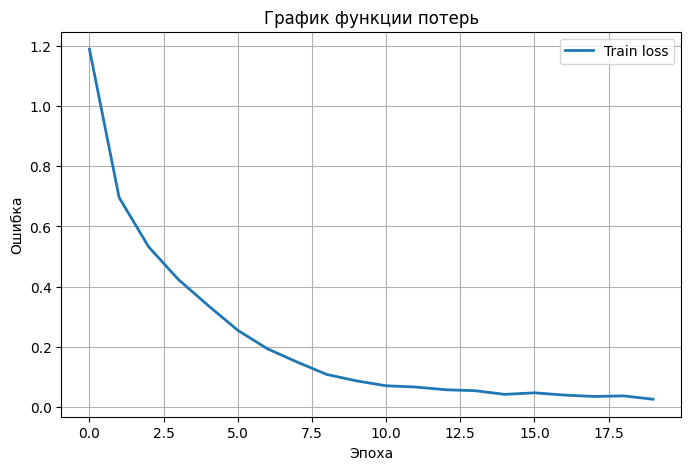

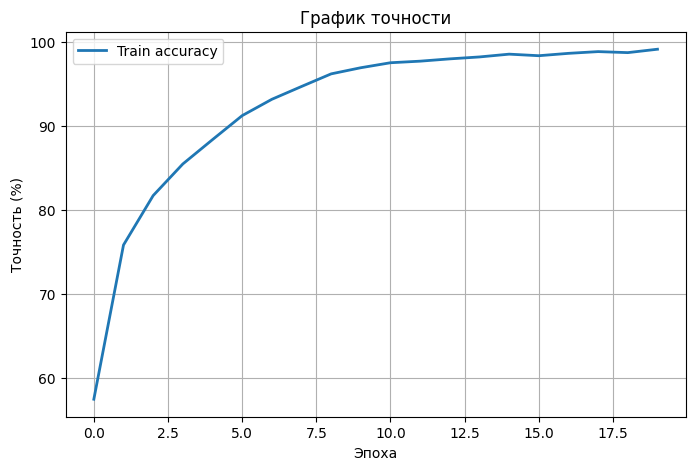

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(train_loss_list, label='Train loss', linewidth=2)
plt.title('График функции потерь')
plt.xlabel('Эпоха')
plt.ylabel('Ошибка')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(train_accuracy_list, label='Train accuracy', linewidth=2)
plt.title('График точности')
plt.xlabel('Эпоха')
plt.ylabel('Точность (%)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
accuracy = model.predict(test_data_loader)
print(f'Точность на тесте = {accuracy:.4f}')

Test accuracy = 0.8678
